In [5]:
import os
import sys
sys.path.append("../") # go to parent dir
import glob
import time
import pathlib
import logging
import numpy as np
from scipy.sparse import linalg as spla
#from dedalus.tools.config import config
#from simple_sphere import SimpleSphere, TensorField, TensorSystem
#import equations
import matplotlib.pyplot as plt
%matplotlib inline
#import cartopy.crs as ccrs
#from dedalus.extras import plot_tools
import logging
from mpl_toolkits import mplot3d
logger = logging.getLogger(__name__) 
from matplotlib.animation import FFMpegWriter

STRNAME = "sphere110"
#add path to data folder
input_folder = "/Users/Rohit/Documents/research/active_matter_spheres/scripts/data"
output_folder = "/Users/Rohit/Documents/research/active_matter_spheres/scripts/garbage"
first_frame = 1
last_frame = len(glob.glob1('%s/%s/' %(input_folder, STRNAME),"*.npz"))
#last_frame = 1000
dpi = 256
Omega = 500

# Setup output folder
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

t_arr = np.zeros(last_frame)
print('Total time stamps = %i' %(last_frame))


Total time stamps = 5000


In [84]:
with np.load('%s/%s/output_%i.npz' %(input_folder, STRNAME, 1)) as file:
    phi = file['phi']
    theta = file['theta']

vph = np.zeros((last_frame, phi.shape[0], theta.shape[0]))
om = np.zeros_like(vph)
    
for ind in range(first_frame, last_frame + 1, 1):
    if ind%100==0: print(ind)
    with np.load('%s/%s/output_%i.npz' %(input_folder, STRNAME, ind)) as file:
        vph[ind-1, :, :] = file['v_ph']
        om[ind-1, :, :] = file['om']
        t_arr[ind-1] = file['t'][0]
        
om_max = np.max(om)
vph_max = np.max(vph)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000


In [7]:
#define function that returns the neutral ell's for a given R/Lambda and kappa
def get_l(Lmid, kappa):
    
    gamma0, gamma2, gamma4 = get_gammas(Lmid, kappa)
    delta_p = (0.5/gamma4)*(-gamma2+np.sqrt(gamma2**2-4*gamma0*gamma4))
    delta_m = (0.5/gamma4)*(-gamma2-np.sqrt(gamma2**2-4*gamma0*gamma4))
    
    l_p = 0.5*(-1+np.sqrt(17+4*delta_p))
    l_m = 0.5*(-1+np.sqrt(17+4*delta_m))
        
    return l_p, l_m

def get_gammas(Lmid, kappa):
    
    a = 0.25*(Lmid**2*kappa**2 - 0.5*(2*np.pi*Lmid+1)**2)**2 + 17*17/16 - (34/16)*(2*np.pi*Lmid+1)**2
    b = (17/4 - 0.25*(2*np.pi*Lmid+1)**2)**2
    c = 1/(17/4 - 0.25*(2*np.pi*Lmid + 1)**2 - 2)
    gamma0 = a*c/(a-b)
    gamma2 = -2*np.sqrt(b)*c/(a-b)
    gamma4 = c/(a-b)
    
    return [gamma0, gamma2, gamma4]



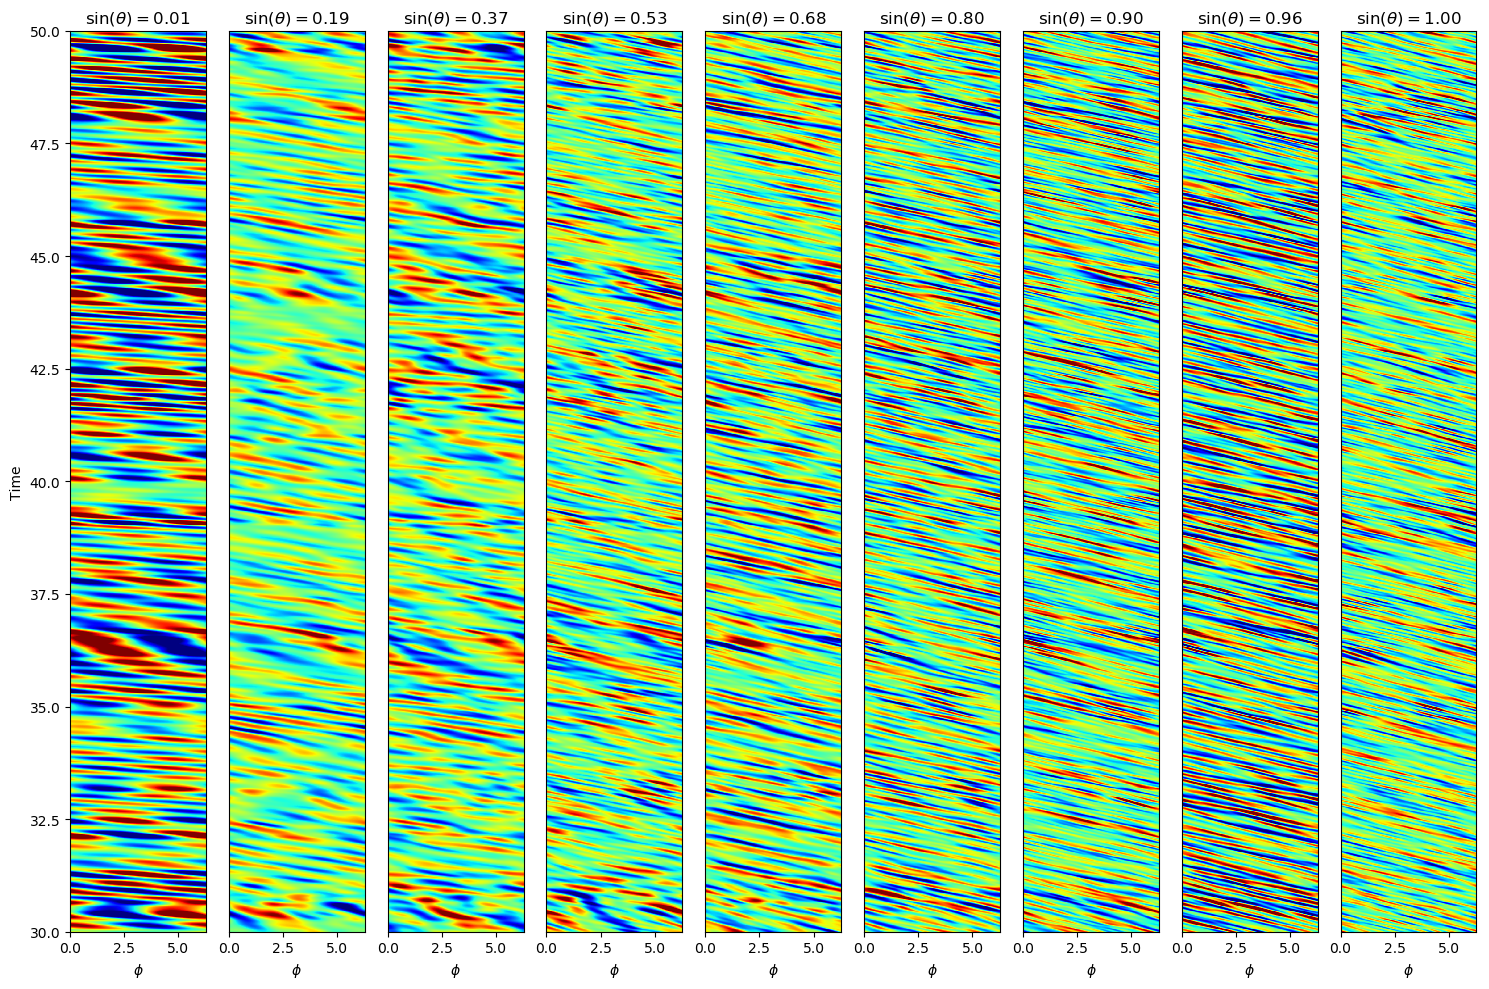

In [8]:
th_inds = np.arange(255, 128, -15, dtype=int)

plt.figure(figsize=(15, 10), dpi=100)

count = 1
for i in th_inds:
    plt.subplot(1, len(th_inds), count)
    plt.pcolormesh(phi, t_arr, vph[:,:,i] - np.mean(vph[:,:,i], axis=1, keepdims=True), cmap='jet' \
                   , vmin=-5, vmax=5)
    plt.ylim([30,50])
    if count != 1: plt.yticks([], [])
    else: plt.ylabel('Time')
    plt.title(r'$\sin(\theta) = %0.2f$' %(np.sin(theta[i])))
    plt.xlabel(r'$\phi$')

    count += 1

plt.tight_layout()
plt.show()

#plt.savefig('../plots/rossby_colorplot.png')


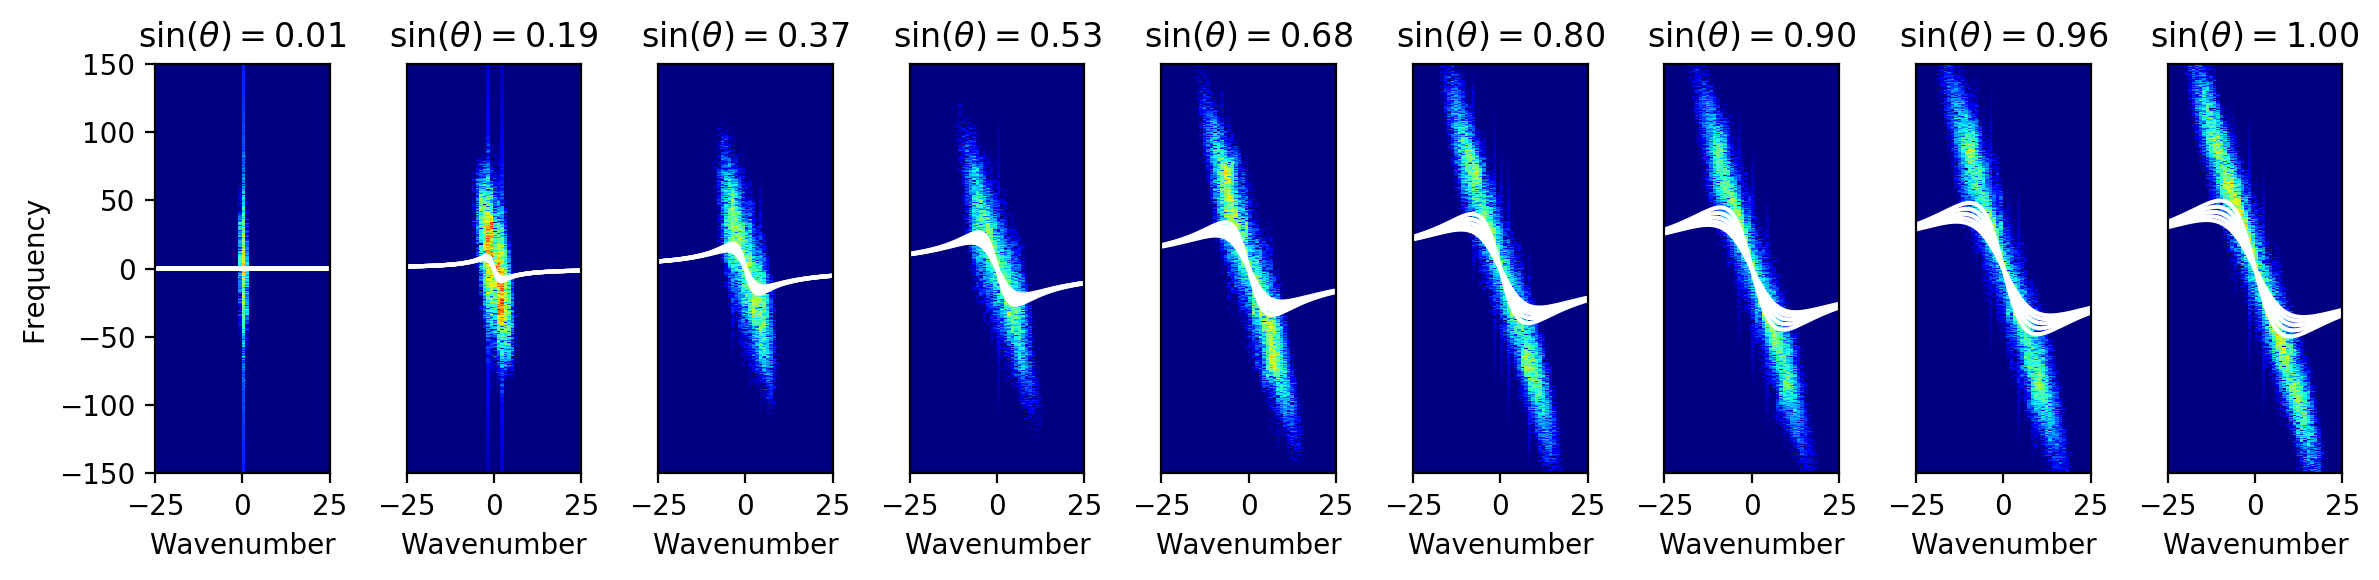

In [9]:
##### Plot FFT ######
plt.figure(figsize=(12, 3), dpi=200)

time_inds = np.arange(3000, 5000, 1)

#set the vertical wavenumber
ky_array = np.arange(10,15,1)

count = 1
for i in th_inds:
    
    sig_eq = om[:, :, i]
    
    sig_fft = np.fft.fft2(sig_eq[time_inds, :])
    sig_fft = np.fft.fftshift(sig_fft)
    dphi = phi[2] - phi[1]
    dt = t_arr[2] - t_arr[1]

    phi_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(phi), d=dphi))
    #time freq is taken to be negative to be consistent with the waves definition
    time_freq = -2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(t_arr[time_inds]), d=dt))
    
    plt.subplot(1, len(th_inds), count)
    plt.pcolormesh(phi_freq, time_freq, np.log10(np.abs(sig_fft)), cmap='jet', vmin=4)
    if count != 1: plt.yticks([], [])
    else: plt.ylabel('Frequency')
    plt.title(r'$\sin(\theta) = %0.2f$' %(np.sin(theta[i])))
    plt.xlabel(r'Wavenumber')
    
    for ky in ky_array:
        plt.plot(phi_freq, -2*Omega*phi_freq/((phi_freq**2/np.sin(theta[i])**2) + ky**2), 'w')
    
    plt.ylim([-150, 150])
    plt.xlim([-25, 25])

    count += 1

plt.tight_layout()
plt.savefig('../plots/%s_disp.png' %(STRNAME))


### Find the ridge

Slope is -7.03


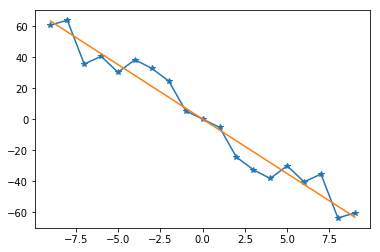

In [10]:
m_max = 10

#find the ridge 
th_ind = 100
sig_eq = om[:, :, th_ind]
sig_fft = np.fft.fft2(sig_eq[time_inds, :])
sig_fft = np.fft.fftshift(sig_fft)
dphi = phi[2] - phi[1]
dt = t_arr[2] - t_arr[1]
phi_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(phi), d=dphi))
time_freq = -2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(t_arr[time_inds]), d=dt))
    
mag = np.abs(sig_fft)
ridge = np.zeros(phi_freq.shape[0])

for i, m in enumerate(phi_freq):
    if np.abs(m)<m_max:
        max_ind = np.argmax(mag[:,i])
        ridge[i] = np.mean(time_freq[max_ind-10:max_ind+10])
    else:
        ridge[i] = np.nan
        
idx = np.isfinite(ridge)
p = np.polyfit(phi_freq[idx], ridge[idx], 1)
fit = np.poly1d(p)
        
plt.figure()
plt.plot(phi_freq, ridge, '*-')
plt.plot(phi_freq[idx], fit(phi_freq[idx]))

print('Slope is %0.2f' %(p[0]))


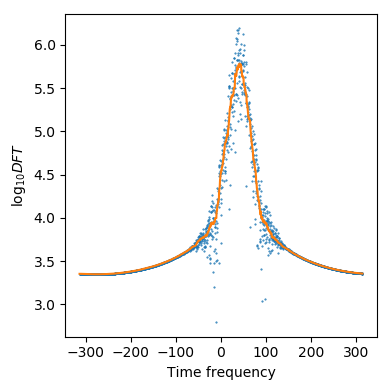

In [11]:
plt.figure(figsize=(4,4), dpi=100)

ind = 250
plt.plot(time_freq, np.log10(mag[:,250]), '.', markersize=1)
phi_freq[ind]

from scipy.optimize import curve_fit
from scipy.signal import find_peaks, find_peaks_cwt, medfilt

def gauss(x, a, mu, sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

xdata = time_freq
ydata = np.log10(mag[:,250])
min_y = np.min(ydata)

popt, pcov = curve_fit(gauss, xdata, ydata-min_y, p0=[1, 40, 20])

maxinds = np.where(np.log10(mag[:,ind]) > np.max(np.log10(mag[:,ind]))-0.5)
ymean = np.mean(np.log10(mag[maxinds,ind]))
xmean = np.mean(time_freq[maxinds])

#plt.plot(xdata, gauss(xdata, popt[0], popt[1], popt[2]) + min_y)
#plt.plot(xmean, ymean, 'r*')

filtered = medfilt(ydata, 51)
plt.plot(xdata, filtered)
plt.xlabel('Time frequency')
plt.ylabel(r'$\log_{10} DFT$')

plt.tight_layout()

plt.savefig('../plots/filtering.pdf')

### Find the slope of the ridges at all angles

In [12]:
th_inds = np.arange(0,256, 5, dtype=int)
slope = np.zeros_like(th_inds, dtype=float)
error_slope = np.zeros_like(th_inds, dtype=float)
time_inds = np.arange(3000, 5000, 1)

for i in range(len(th_inds)):
    if i%10==0: print(i)

    sig_eq = om[:, :, th_inds[i]]
    sig_fft = np.fft.fft2(sig_eq[time_inds, :])
    sig_fft = np.fft.fftshift(sig_fft)
    dphi = phi[2] - phi[1]
    dt = t_arr[2] - t_arr[1]
    phi_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(phi), d=dphi))
    time_freq = -2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(t_arr[time_inds]), d=dt))
    
    mag = np.abs(sig_fft)
    ridge = np.zeros(phi_freq.shape[0])
    ridge2 = np.zeros(phi_freq.shape[0])

    for j, m in enumerate(phi_freq):
        if np.abs(m)<m_max:
            #### method 1
            #maxinds = np.where(np.log10(mag[:,j]) > np.max(np.log10(mag[:,j]))-0.5)
            #xmean = np.mean(time_freq[maxinds])
            #ridge[j] = xmean
            
            #### method 2
            #delta_inds = 50
            #max_ind = np.argmax(mag[:,j])
            #ridge[j] = np.mean(time_freq[max_ind-delta_inds:max_ind+delta_inds])
            
            #### method 3 - median filter
            filtered = medfilt(np.log10(mag[:,j]), 51)
            max_ind = np.argmax(filtered)
            ridge[j] = time_freq[max_ind]
            
            filtered2 = medfilt(np.log10(mag[:,j]), 1)
            max_ind2 = np.argmax(filtered2)
            ridge2[j] = time_freq[max_ind2]
        
        else:
            ridge[j] = np.nan
            ridge2[j] = np.nan

    idx = np.isfinite(ridge)
    p = np.polyfit(phi_freq[idx], ridge[idx], 1)
    
    idx2 = np.isfinite(ridge2)
    p2 = np.polyfit(phi_freq[idx2], ridge2[idx2], 1)
    
    slope[i] = p[0]
    error_slope[i] = np.abs(p[0]-p2[0])
    


0
10
20
30
40
50


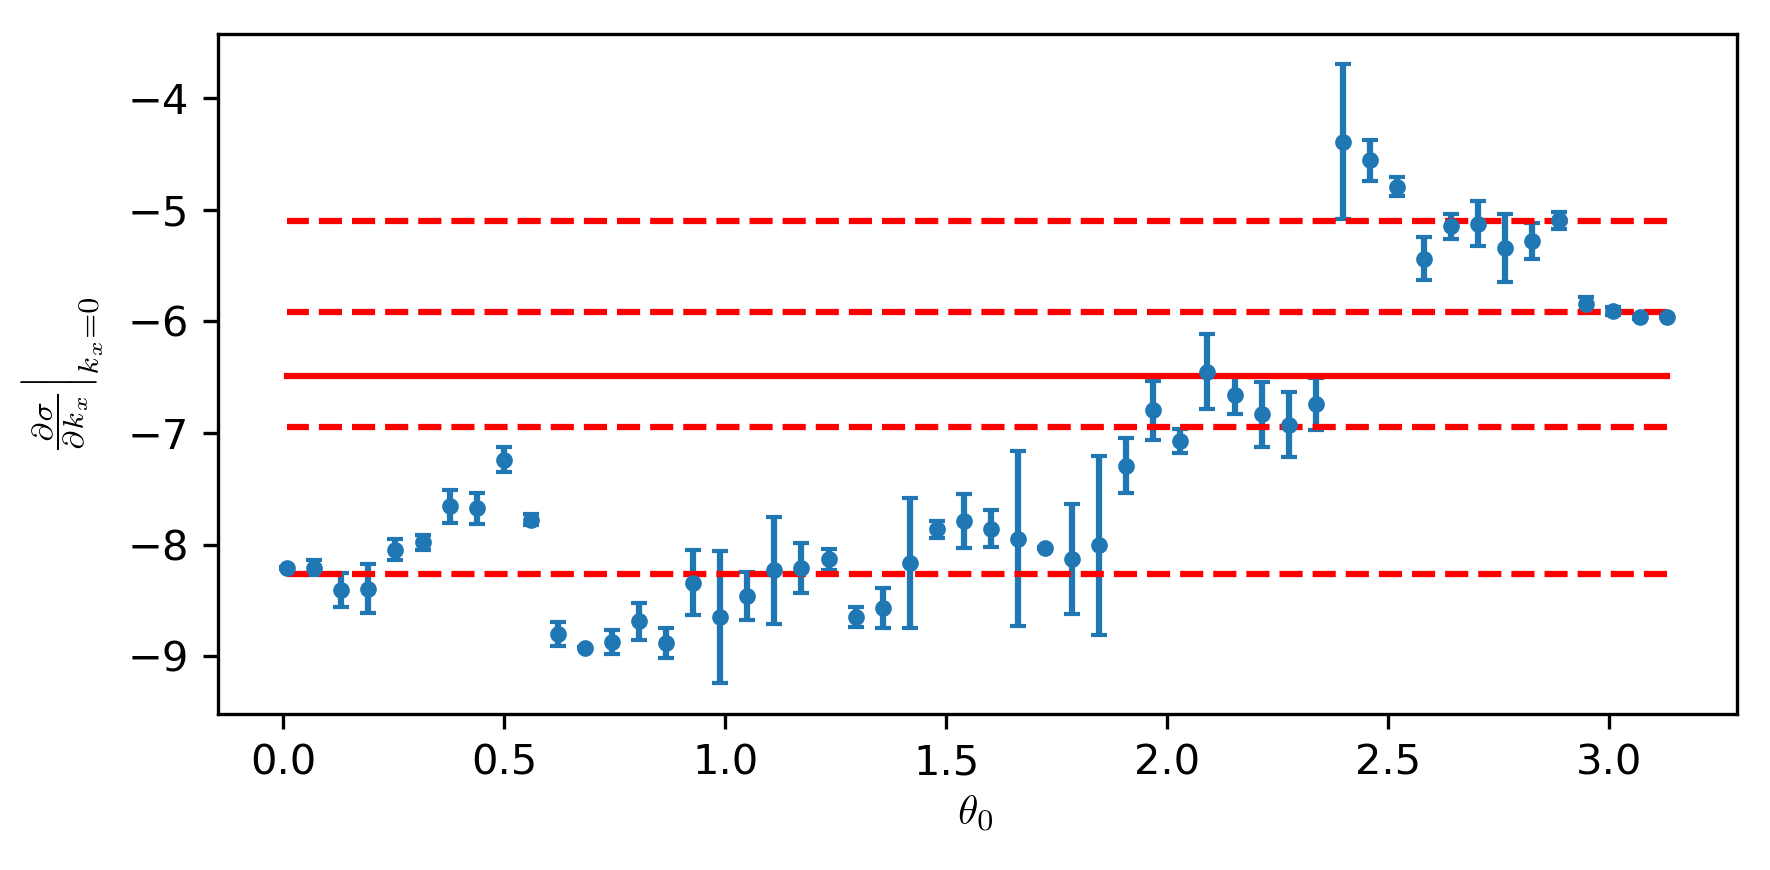

In [13]:
plt.figure(figsize=(6,3), dpi=300)
    
#plt.plot(theta[th_inds], slope*np.sin(theta[th_inds]), '*', markersize=2)  
plt.errorbar(theta[th_inds], slope*np.ones_like(theta[th_inds]), yerr=error_slope*np.sin(theta[th_inds]), fmt='o', \
            markersize=3, capsize=2)
l_p, l_m = get_l(4,1)
lmax0 = ((l_p+l_m)/2)

lmax_arr = np.arange(11, 15,1)
for lmax in lmax_arr:
    c0 = (-2*Omega/(lmax**2))*np.ones_like(theta[th_inds])
    plt.plot(theta[th_inds], c0, 'r--')

c00 = (-2*Omega/(lmax0**2))*np.ones_like(theta[th_inds])
plt.plot(theta[th_inds], c00, 'r-')
    
#plt.ylim([c00-2, c00+2])
plt.ylabel(r'$\left. \frac{\partial \sigma}{\partial k_x}  \right|_{k_x=0}$', usetex=True)
plt.xlabel(r'$\theta_0$', usetex=True)
plt.tight_layout()

plt.savefig('../plots/%s_slope_mod.pdf' %(STRNAME))

##### Below, we find the 2D FFT of the data for $\zeta$ for $0<\phi<2 \pi$ and over a $\theta$ interval

Time is 45.001000


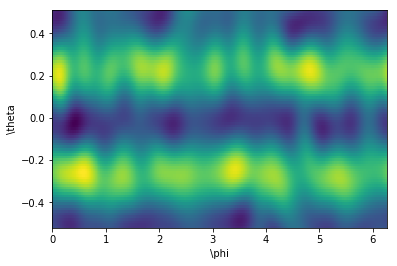

In [60]:
theta_window = 60 #total window size over which to do fft
lat = (np.pi/2 - theta) * 180 / np.pi
th = np.pi/2 - theta #latitude in radians 
#get inds 
ind1 = (np.abs(lat + theta_window/2)).argmin()
ind2 = (np.abs(lat - theta_window/2)).argmin()
th_inds = np.arange(ind1, ind2, 1, dtype=int)

t_ind = 4500
print('Time is %f' %(t_arr[t_ind]))

plt.pcolor(phi, th[th_inds], om[t_ind, :, th_inds])
plt.xlabel(r'\phi'); plt.ylabel(r'\theta');

#find FFT 
om_fft2 = np.fft.fftshift(np.fft.fft2(om[t_ind, :, th_inds]))
om_fft_log = np.log10(np.abs(om_fft2))
om_fft_abs = np.abs(om_fft2)

#find frequencies 
dphi = phi[2] - phi[1]
dth = th[2] - th[1]
th_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(th[th_inds]), d=dth))
phi_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(phi), d=dphi))


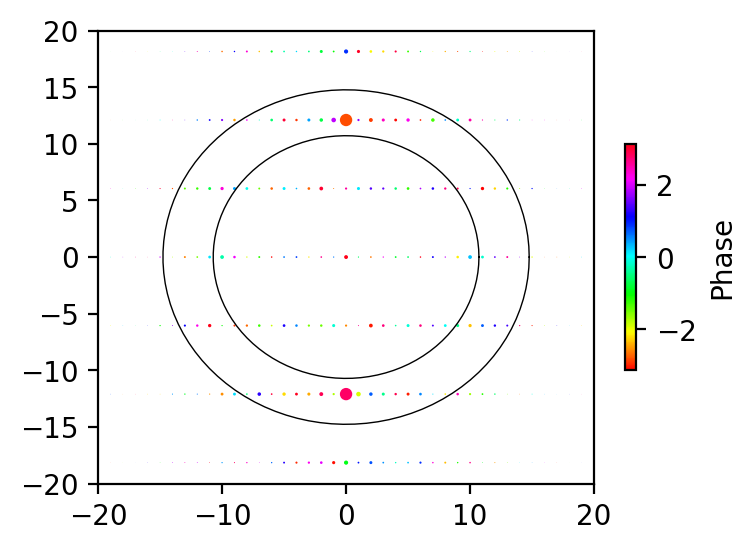

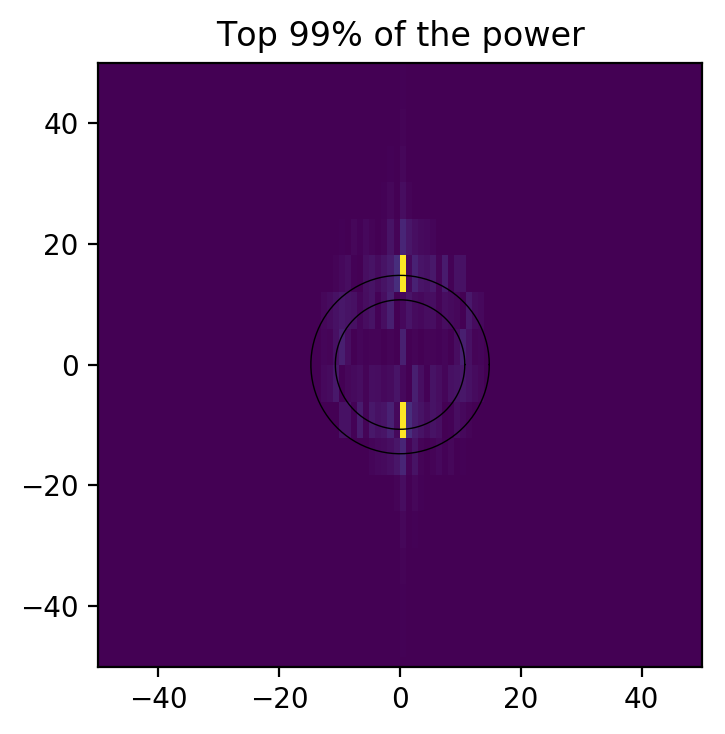

In [126]:
phase = np.angle(om_fft2)
mag = np.abs(om_fft2)
kxkx, kyky = np.meshgrid(phi_freq, th_freq)

#plot the most unstable mode
γ0, γ2, γ4 = get_gammas(4, 1)
k_max = np.sqrt(-γ2/(2*γ4))
k_m = np.sqrt((-γ2 - np.sqrt(γ2**2 - 4*γ0*γ4))/(2*γ4))
k_p = np.sqrt((-γ2 + np.sqrt(γ2**2 - 4*γ0*γ4))/(2*γ4))

##
fig = plt.figure(figsize=(4,3), dpi=200)
img = plt.scatter(kxkx.flatten(), kyky.flatten(), 1e-5*mag.flatten(), \
            c=phase.flatten(), edgecolor='none', cmap = 'hsv')
plt.ylim([-20, 20])
plt.xlim([-20, 20])
clb = fig.colorbar(img, shrink=0.5)
clb.set_label('Phase')
plt.plot(k_m*np.cos(th_temp), k_m*np.sin(th_temp), 'k', linewidth=0.5)
plt.plot(k_p*np.cos(th_temp), k_p*np.sin(th_temp), 'k', linewidth=0.5)

#plot the FFT amplitude
plt.figure(figsize=(8,4), dpi=200)
plt.pcolormesh(phi_freq, th_freq, om_fft_abs)
#plt.colorbar(); 
plt.clim([0.01*np.max(om_fft_abs), np.max(om_fft_abs)])
plt.axis('scaled')
plt.ylim([-50, 50]); plt.xlim([-50, 50])
plt.title('Top 99% of the power')


th_temp = np.linspace(0,2*np.pi, 100)
#plt.plot(k_p*np.cos(th_temp), k_max*np.sin(th_temp), 'k', linewidth=0.5)
plt.plot(k_m*np.cos(th_temp), k_m*np.sin(th_temp), 'k', linewidth=0.5)
plt.plot(k_p*np.cos(th_temp), k_p*np.sin(th_temp), 'k', linewidth=0.5)

### Make video

The FFT plot must be sensitive to the time point that is chosen. Let us see how the modes in the Fourier space evolve around the equator. This can also serve as a good test for the beta-plane approximation. 

In [ ]:
plt.rc('text', usetex=False)

fig = plt.figure(figsize=(8,3))

dpi = 300
FPS = 15
metadata = dict(title='Movie', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=FPS, metadata=metadata)
edgecolor = 'k'
axes1 = plt.axes((0.1, 0.1, 0.4, 0.8))
axes4 = plt.axes((0.5, 0.1, 0.4, 0.8))

first_frame = 0
last_frame = 3000

#plot the most unstable mode
γ0, γ2, γ4 = get_gammas(4, 1)
k_max = np.sqrt(-γ2/(2*γ4))
k_m = np.sqrt((-γ2 - np.sqrt(γ2**2 - 4*γ0*γ4))/(2*γ4))
k_p = np.sqrt((-γ2 + np.sqrt(γ2**2 - 4*γ0*γ4))/(2*γ4))
    
kxkx, kyky = np.meshgrid(phi_freq, th_freq)
mag_fac = 1e-5
with writer.saving(fig, "../videos/sphere110_beta_plane.mp4", dpi):
    
    for i in range(first_frame, last_frame + 1, 1):
        if i%10==0: print('Frame: %i' %(i))
        
        #find FFT 
        om_fft2 = np.fft.fftshift(np.fft.fft2(om[i, :, th_inds]))
        om_fft_log = np.log10(np.abs(om_fft2))
        mag = np.abs(om_fft2)
        phase = np.angle(om_fft2)
        time = t_arr[i]

        # Create plots
        if i == first_frame:
            
            plt.subplot(121)
            image1 = plt.pcolor(phi, th[th_inds], om[i, :, th_inds], vmax=om_max, cmap='RdBu_r')
            plt.xlabel(r'$\phi$'); plt.ylabel(r'$\theta$');
            
            plt.subplot(122)
            image2 = plt.scatter(kxkx.flatten(), kyky.flatten(), mag_fac**mag.flatten(), \
            c=phase.flatten(), edgecolor='none', cmap = 'hsv')
            plt.ylim([-20, 20])
            plt.xlim([-20, 20])
            clb = fig.colorbar(img, shrink=0.5)
            clb.set_label('Phase')
            plt.plot(k_m*np.cos(th_temp), k_m*np.sin(th_temp), 'k', linewidth=0.5)
            plt.plot(k_p*np.cos(th_temp), k_p*np.sin(th_temp), 'k', linewidth=0.5)
            title = fig.suptitle('t = %.4f' %time)
            plt.xlabel(r'$k_x$');
            plt.ylabel(r'$k_y$')
            
            plt.tight_layout()

            
            #image2 = plt.pcolor(phi_freq, th_freq, om_fft_abs)
            #plt.colorbar(); 
            #plt.clim([0.01*np.max(om_fft_abs), np.max(om_fft_abs)])
            #plt.axis('scaled')
            #plt.ylim([-50, 50]); plt.xlim([-50, 50])
            
            #plt.plot(k_m*np.cos(th_temp), k_m*np.sin(th_temp), 'k', linewidth=0.5)
            #plt.plot(k_p*np.cos(th_temp), k_p*np.sin(th_temp), 'k', linewidth=0.5)

        # Update plot
        else:
            image1.set_array(om[i, :, th_inds][:-1,:-1].ravel())
            image2.set_sizes(mag_fac*mag.flatten())
            image2.set_array(phase.flatten())
            
            title.set_text('t = %.4f' %time)
                
        
        writer.grab_frame()

Frame: 0
Frame: 10
Frame: 20
Frame: 30


/Users/Rohit/anaconda3/envs/mayavi/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10


Frame: 40
Frame: 50
Frame: 60
Frame: 70
Frame: 80
Frame: 90
Frame: 100
Frame: 110
Frame: 120
Frame: 130
Frame: 140
Frame: 150
Frame: 160
Frame: 170
Frame: 180
Frame: 190
Frame: 200
Frame: 210
Frame: 220
Frame: 230
Frame: 240
Frame: 250
Frame: 260
Frame: 270
Frame: 280
Frame: 290
Frame: 300
Frame: 310
Frame: 320
Frame: 330
Frame: 340
Frame: 350
Frame: 360
Frame: 370
Frame: 380
Frame: 390
Frame: 400
Frame: 410
Frame: 420
Frame: 430
Frame: 440
Frame: 450
Frame: 460
Frame: 470
Frame: 480
Frame: 490
Frame: 500
Frame: 510
Frame: 520
Frame: 530
Frame: 540
Frame: 550
Frame: 560
Frame: 570
Frame: 580
Frame: 590
Frame: 600
Frame: 610
Frame: 620
Frame: 630
Frame: 640
Frame: 650
Frame: 660
Frame: 670
Frame: 680
Frame: 690
Frame: 700
Frame: 710
Frame: 720
Frame: 730
Frame: 740
Frame: 750
Frame: 760
Frame: 770
Frame: 780
Frame: 790
Frame: 800
Frame: 810
Frame: 820
Frame: 830
Frame: 840
Frame: 850
Frame: 860
Frame: 870
Frame: 880
Frame: 890
Frame: 900
Frame: 910
Frame: 920
Frame: 930
Frame: 940
Frame

In [14]:
theta_window = 60 #total window size over which to do fft
lat = (np.pi/2 - theta) * 180 / np.pi
th = np.pi/2 - theta #latitude in radians 
#get inds 
ind1 = (np.abs(lat + theta_window/2)).argmin()
ind2 = (np.abs(lat - theta_window/2)).argmin()
t_inds = np.arange(4500, t_arr.shape[0], 1, dtype=int)

#### Plot the analytical dispersion relation 

$$
\sigma = \frac{-\beta k_x}{k_x^2 + k_y^2}
$$

In [ ]:
k0_ = 12
kx_, ky_ = np.meshgrid(np.linspace(-20, 20, 100), np.linspace(-20, 20, 100))
sig_ = -2*Omega*kx_/k0_**2

from mayavi import mlab
from mayavi.mlab import *
mlab.init_notebook()

surf(kx_, ky_, sig_)



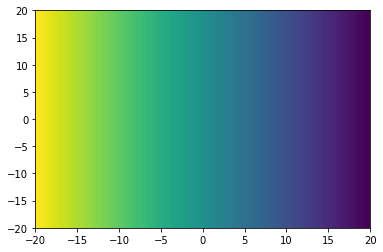

In [20]:
plt.pcolor(kx_, ky_, sig_)

In [16]:
#find FFT 
om_fft = np.fft.fftshift(np.fft.fftn(om[t_inds, :, ind1:ind2]))

In [17]:
dphi = phi[2] - phi[1]
dt = t_arr[2] - t_arr[1]
dth = th[2] - th[1]
th_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(th[ind1:ind2]), d=dth))
phi_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(phi), d=dphi))
time_freq = -2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(t_arr[t_inds]), d=dt))

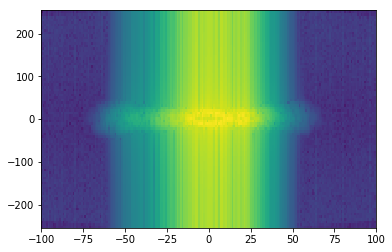

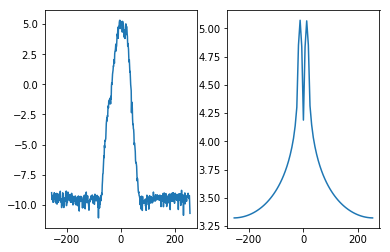

In [24]:
plt.pcolor(phi_freq, th_freq, np.log10(np.abs(om_fft[400, :, :])).T)
plt.xlim([-100, 100])

plt.figure()
plt.subplot(121)
plt.plot(phi_freq, np.log10(np.abs(om_fft[400, :, 40])))
plt.subplot(122)
plt.plot(th_freq, np.log10(np.abs(om_fft[400, 256, :])))

In [22]:
phi_freq.shape

(512,)

In [24]:
from mayavi import mlab
from mayavi.mlab import *
mlab.init_notebook()
sig, kx, ky = np.meshgrid(time_freq, phi_freq, th_freq, indexing='ij')

contour3d(sig, kx, ky, np.log10(np.abs(om_fft)), contours=4,  transparent=True)


Notebook initialized with x3d backend.


In [31]:
om_fft.shape

(4000, 512, 85)

In [23]:
import numpy
from mayavi.mlab import *

def test_contour3d():
    x, y, z = np.ogrid[-5:5:64j, -5:5:64j, -5:5:64j]

    scalars = x * x * 0.5 + y * y + z * z * 2.0

    obj = contour3d(scalars, contours=4, transparent=True)
    return obj

In [ ]:
test_contour3d()